In [1]:
import numpy as np
import matplotlib.pyplot as plt
from prob_path_function import *

# 1. Uniform to Poisson-Gamma-mixture

In [2]:
shapes1 = np.array([10.0, 50.0])
rates1  = np.array([1.0, 1.0])
probs1  = np.array([0.5, 0.5])

def target_sampler(N):
    return sample_gamma_poisson_mixture(N, shapes1, rates1, probs1)

In [3]:
T_all = 1000
M = 1000

## 1.1 Prob path over time

In [4]:
# 1. Binomial
X_t_all_binom, t_grid_binom, _ = build_time_prob_path(
    T_steps=T_all,
    M_samples=M,
    sample_xt=binBridge_sample_xt,
    source_sampler=sample_uniform_counts,
    target_sampler=target_sampler,
    t0=0.0,
    t1=1.0,
    seed=0
)

# 2. Dirichlet
tmp = target_sampler(50000)
_, C_max = build_count_dataset_np(tmp, C_max=None, margin=2)
K = C_max + 1
alpha_max = alpha_max_for_eps(K, eps=0.1)
X_t_all_DirFM, t_grid_dir, _ = build_time_prob_path(
    T_steps=T_all,
    M_samples=M,
    sample_xt=dirBridge_sample_xt,
    source_sampler=sample_uniform_counts,   # x0 ignored inside, but OK
    target_sampler=target_sampler,
    C_max=C_max,
    xt_kwargs={"K": K, "alpha_max": alpha_max},
    target_clip_margin=0,
    t0=0.0,
    t1=alpha_max,
    seed=0
)

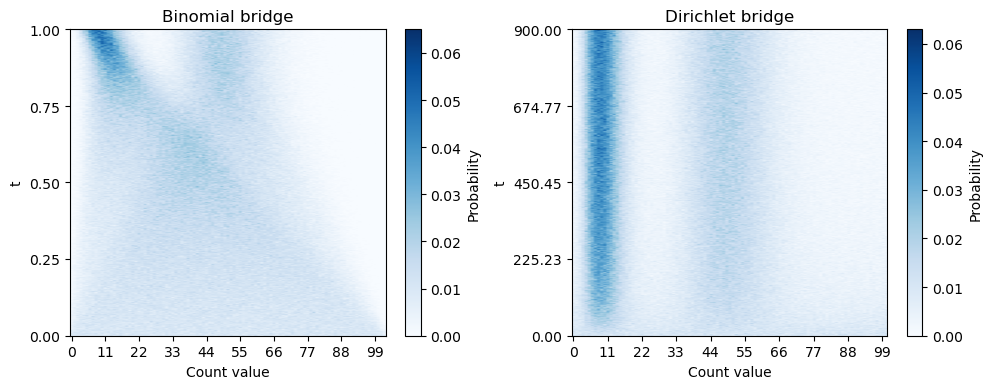

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_count_prob_path_from_samples(
    X_t_all_binom,
    t_grid=t_grid_binom,
    max_xticks=10,
    ax=axes[0]
)
axes[0].set_title("Binomial bridge")

plot_count_prob_path_from_samples(
    X_t_all_DirFM,
    t_grid=t_grid_dir,
    max_xticks=10,
    ax=axes[1]
)
axes[1].set_title("Dirichlet bridge")

plt.show()

## 1.2 Prob path over relative entropy

- The entropy: $H(t) = -\sum_x p_t(x)\log p_t(x)$
- normalized entropy: $\eta(t) = \frac{H(t) - H(1)}{H(0) - H(1)}$
- So, $\eta(1) = 0$ corresponds to data, $\eta(0) = 1$ corresponds to source noise.

**In Dirichlet bridge paper, $\tilde{t} = \infty$ corresponds to data. Here, I rescale $\tilde{t}$ to $t = \frac{\alpha(\tilde{t}) - 1}{\alpha_{max} - 1} \in [0,1]$**

In [6]:
X_binom_eta, t_rows_binom, eta_rows_binom, H_binom, eta_grid_binom = build_entropy_aligned_path(
    T_rows=T_all,
    M_samples=M,
    sample_xt=binBridge_sample_xt,
    source_sampler=sample_uniform_counts,
    target_sampler=target_sampler,
    C_max=C_max,
    xt_kwargs={},
    target_clip_margin=0,
    t0=0.0,
    t1=1.0,
    T_entropy_grid=max(50, T_all),
    seed=0
)

In [7]:
alpha_max = alpha_max_for_eps(K, eps=0.01)
X_dir_eta, t_rows_dir, eta_rows_dir, H_dir, eta_grid_dir = build_entropy_aligned_path(
    T_rows=T_all,
    M_samples=M,
    sample_xt=dirBridge_sample_xt,
    source_sampler=sample_uniform_counts,
    target_sampler=target_sampler,
    C_max=C_max,
    xt_kwargs={"K": K, "alpha_max": alpha_max},
    target_clip_margin=0,
    t0=0.0,
    t1=alpha_max,
    T_entropy_grid=max(50, T_all),
    seed=0
)

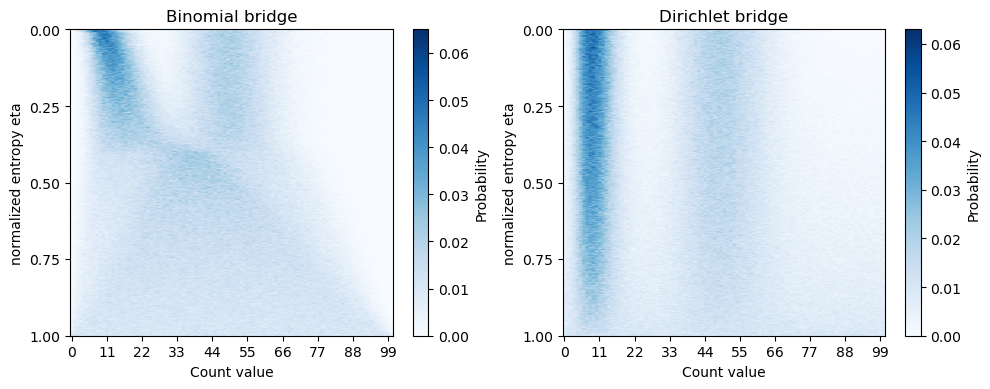

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_count_prob_path_vs_noise(
    X_binom_eta,
    eta_rows_binom,
    max_xticks=10,
    ax=axes[0]
)
axes[0].set_title("Binomial bridge")
plot_count_prob_path_vs_noise(
    X_dir_eta,
    eta_rows_dir,
    max_xticks=10,
    ax=axes[1]
)
axes[1].set_title("Dirichlet bridge")
plt.show()

In terms of entropy (~ SNR), the Dirichlet FM is almost equivalent to 1-step learning. --> very aggresive, that's why Dirichlet FM paper use $t \sim Exp(\theta)$

# 2. 2-mixture to 3-mixture (beta-binomial mixtures)

In [9]:
n0 = 60
n1 = 60

# concentration (larger = sharper)
S0 = 200.0
S1 = 200.0

mu0 = np.array([20.0, 40.0])
p0  = mu0 / n0
a0  = p0 * S0
b0  = (1.0 - p0) * S0
probs0 = np.array([0.5, 0.5])

mu1 = np.array([10.0, 30.0, 50.0])
p1  = mu1 / n1
a1  = p1 * S1
b1  = (1.0 - p1) * S1
probs1 = np.array([0.3, 0.4, 0.3])

def sampler_p0(N, C_max=None):
    return sample_beta_binomial_mixture(
        N,
        n_vec=np.full(2, n0),
        alpha_vec=a0,
        beta_vec=b0,
        probs=probs0,
    )

def sampler_p1(N):
    return sample_beta_binomial_mixture(
        N,
        n_vec=np.full(3, n1),
        alpha_vec=a1,
        beta_vec=b1,
        probs=probs1,
    )

In [10]:
X_t_all_binom_23, t_grid_binom_23, _ = build_time_prob_path(
    T_steps=T_all,
    M_samples=M,
    sample_xt=binBridge_sample_xt,
    source_sampler=sampler_p0,
    target_sampler=sampler_p1,
    t0=0.0,
    t1=1.0,
    seed=0
)

Text(0.5, 1.0, '4 mode at t = 0.5')

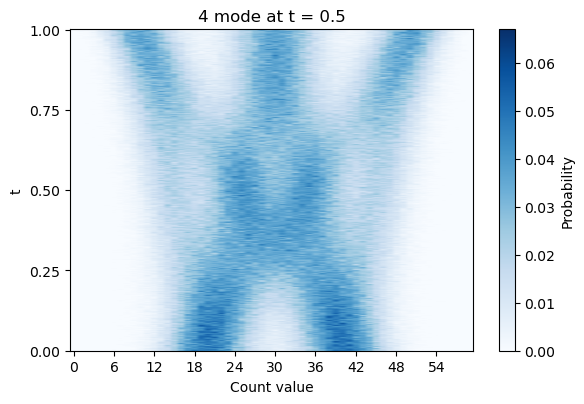

In [11]:
plot_count_prob_path_from_samples(
    X_t_all_binom_23,
    t_grid=t_grid_binom_23,
    max_xticks=10,
);
plt.title('4 mode at t = 0.5')

May need a more dispersed bridge --> beta-binomial bridge?
- Do we have this kind of multimodal data?